### Импорты

In [ ]:
!pip -q install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

In [ ]:
dataset = Planetoid('/content/CitationFull', 'Cora')
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Cora()
------------
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [ ]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### Графовая Рекуррентная Нейронная сеть

In [ ]:
class GraphRecurrentNetwork(nn.Module):
    def __init__(self):
        super(GraphRecurrentNetwork, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 128)
        self.dropout1 = torch.nn.Dropout(p=0.4)
        self.rnn = nn.RNN(128, 16, batch_first=True)
        self.dropout2 = torch.nn.Dropout(p=0.4)
        self.rnn2 = nn.RNN(16, 16, batch_first=True)
        self.dropout3 = torch.nn.Dropout(p=0.4)
        self.fc = nn.Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.dropout1(x)
        h_0 = torch.zeros(1, 1, self.rnn.hidden_size)
        out, _ = self.rnn(x.unsqueeze(0), h_0)
        x = out.squeeze(0)
        x = self.dropout2(x)
        h_1 = torch.zeros(1, 1, self.rnn2.hidden_size)
        out, _ = self.rnn2(x.unsqueeze(0), h_1)
        x = self.dropout3(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

model = GraphRecurrentNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

GraphRecurrentNetwork(
  (conv1): GCNConv(1433, 128)
  (dropout1): Dropout(p=0.4, inplace=False)
  (rnn): RNN(128, 16, batch_first=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (rnn2): RNN(16, 16, batch_first=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[data.test_mask].max(dim=1)[1]
    correct = pred.eq(data.y[data.test_mask])
    acc = correct.sum().item() / len(data.y[data.test_mask])
    return acc

In [ ]:
accuracies = []
losses = []
test_accuracies = []
for epoch in range(15):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss)
    pred = out[data.train_mask].max(dim=1)[1]
    correct = pred.eq(data.y[data.train_mask])
    acc = correct.sum().item() / len(data.y[data.train_mask])
    accuracies.append(acc)
    test_acc = test()
    test_accuracies.append(test_acc)
    if epoch%1==0:
      print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}% | Test_Acc: {test_acc*100:.2f}%')


Epoch   0 | Loss: 2.01 | Acc: 13.57% | Test_Acc: 35.90%
Epoch   1 | Loss: 1.72 | Acc: 55.00% | Test_Acc: 53.70%
Epoch   2 | Loss: 1.44 | Acc: 83.57% | Test_Acc: 69.60%
Epoch   3 | Loss: 1.18 | Acc: 97.86% | Test_Acc: 75.00%
Epoch   4 | Loss: 0.98 | Acc: 99.29% | Test_Acc: 75.70%
Epoch   5 | Loss: 0.81 | Acc: 100.00% | Test_Acc: 74.20%
Epoch   6 | Loss: 0.67 | Acc: 100.00% | Test_Acc: 74.60%
Epoch   7 | Loss: 0.56 | Acc: 100.00% | Test_Acc: 74.90%
Epoch   8 | Loss: 0.47 | Acc: 100.00% | Test_Acc: 75.50%
Epoch   9 | Loss: 0.39 | Acc: 100.00% | Test_Acc: 75.30%
Epoch  10 | Loss: 0.33 | Acc: 100.00% | Test_Acc: 75.80%
Epoch  11 | Loss: 0.28 | Acc: 100.00% | Test_Acc: 75.80%
Epoch  12 | Loss: 0.24 | Acc: 100.00% | Test_Acc: 75.80%
Epoch  13 | Loss: 0.21 | Acc: 100.00% | Test_Acc: 75.90%
Epoch  14 | Loss: 0.18 | Acc: 100.00% | Test_Acc: 76.60%


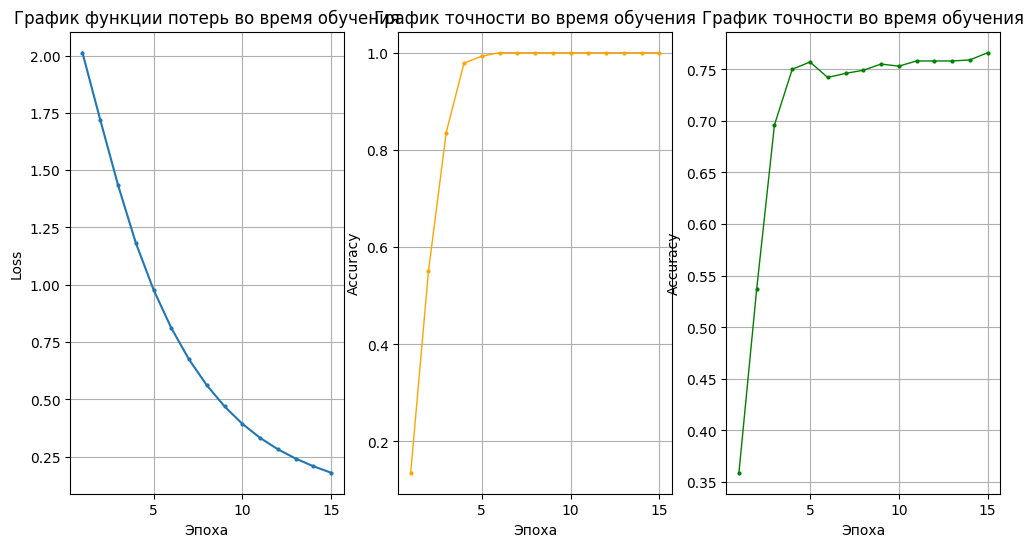

In [ ]:
epochs = list(range(1, len(losses) + 1))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.plot(epochs,  [loss.detach().numpy() for loss in losses], marker='o', linestyle='-', markersize=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('График функции потерь во время обучения')
ax1.grid(True)
ax2.plot(epochs, accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='orange')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy')
ax2.set_title('График точности во время обучения')
ax2.grid(True)
ax3.plot(epochs, test_accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='green')
ax3.set_xlabel('Эпоха')
ax3.set_ylabel('Accuracy')
ax3.set_title('График точности во время обучения')
ax3.grid(True)
plt.show()

### Графовая Линейная Нейронная сеть

In [ ]:
class GraphLinearClassifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = torch.nn.Linear(dataset.num_features, 10)
    self.fc2 = torch.nn.Linear(10, dataset.num_classes)

  def forward(self, x):
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    return x

model2 = GraphLinearClassifier()
print(model2)

GraphLinearClassifier(
  (fc1): Linear(in_features=1433, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=7, bias=True)
)


In [ ]:
def test():
    model2.eval()
    out = model2(data.x)
    pred = out[data.test_mask].max(dim=1)[1]
    correct = pred.eq(data.y[data.test_mask])
    acc = correct.sum().item() / len(data.y[data.test_mask])
    return acc

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

embeddings = []
losses = []
accuracies = []
outputs = []
test_accuracies = []
for epoch in range(251):
    optimizer.zero_grad()
    output = model2(data.x)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    acc = accuracy(output[data.train_mask].argmax(dim=1), data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(output[data.train_mask].argmax(dim=1))
    test_acc = test()
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}% | Test_Acc: {test_acc*100:.2f}%')

Epoch   0 | Loss: 1.95 | Acc: 13.57% | Test_Acc: 11.80%
Epoch  10 | Loss: 1.95 | Acc: 17.14% | Test_Acc: 11.90%
Epoch  20 | Loss: 1.95 | Acc: 20.00% | Test_Acc: 12.30%
Epoch  30 | Loss: 1.94 | Acc: 22.14% | Test_Acc: 12.60%
Epoch  40 | Loss: 1.94 | Acc: 23.57% | Test_Acc: 13.00%
Epoch  50 | Loss: 1.94 | Acc: 25.00% | Test_Acc: 13.00%
Epoch  60 | Loss: 1.93 | Acc: 28.57% | Test_Acc: 13.00%
Epoch  70 | Loss: 1.93 | Acc: 29.29% | Test_Acc: 13.40%
Epoch  80 | Loss: 1.93 | Acc: 30.00% | Test_Acc: 14.10%
Epoch  90 | Loss: 1.93 | Acc: 29.29% | Test_Acc: 14.50%
Epoch 100 | Loss: 1.92 | Acc: 28.57% | Test_Acc: 15.00%
Epoch 110 | Loss: 1.92 | Acc: 30.71% | Test_Acc: 14.90%
Epoch 120 | Loss: 1.92 | Acc: 31.43% | Test_Acc: 14.80%
Epoch 130 | Loss: 1.91 | Acc: 31.43% | Test_Acc: 14.80%
Epoch 140 | Loss: 1.91 | Acc: 30.71% | Test_Acc: 14.70%
Epoch 150 | Loss: 1.90 | Acc: 30.00% | Test_Acc: 14.40%
Epoch 160 | Loss: 1.90 | Acc: 30.00% | Test_Acc: 14.60%
Epoch 170 | Loss: 1.90 | Acc: 30.71% | Test_Acc:

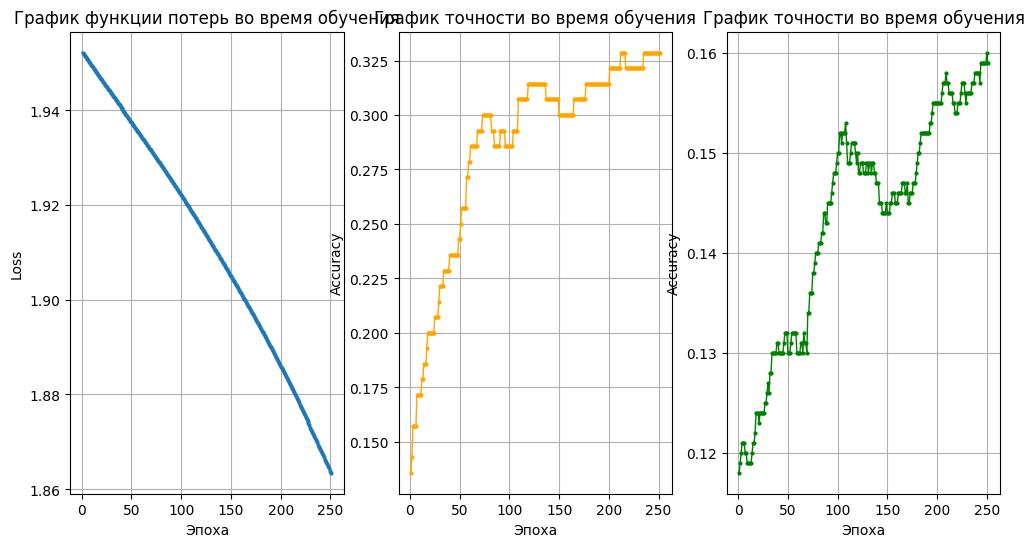

In [ ]:
epochs = list(range(1, len(losses) + 1))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.plot(epochs,  [loss.detach().numpy() for loss in losses], marker='o', linestyle='-', markersize=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('График функции потерь во время обучения')
ax1.grid(True)
ax2.plot(epochs, accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='orange')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy')
ax2.set_title('График точности во время обучения')
ax2.grid(True)
ax3.plot(epochs, test_accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='green')
ax3.set_xlabel('Эпоха')
ax3.set_ylabel('Accuracy')
ax3.set_title('График точности во время обучения')
ax3.grid(True)
plt.show()

### Графовая Сверточная Нейронная сеть

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 10)
        self.out = torch.nn.Linear(10, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model3 = GCN()
print(model3)

GCN(
  (gcn): GCNConv(1433, 10)
  (out): Linear(in_features=10, out_features=7, bias=True)
)


In [ ]:
def test():
    model3.eval()
    out, z = model3(data.x, data.edge_index)
    acc = accuracy(z[data.test_mask].argmax(dim=1), data.y[data.test_mask])
    return acc

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.003)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

embeddings = []
losses = []
accuracies = []
outputs = []
test_accuracies = []
for epoch in range(251):
    optimizer.zero_grad()
    h, z = model3(data.x, data.edge_index)
    loss = criterion(z[data.train_mask], data.y[data.train_mask])
    acc = accuracy(z[data.train_mask].argmax(dim=1), data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z[data.train_mask].argmax(dim=1))
    test_acc = test()
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}% | Test_Acc: {test_acc*100:.2f}%')

Epoch   0 | Loss: 1.96 | Acc: 14.29% | Test_Acc: 10.50%
Epoch  10 | Loss: 1.75 | Acc: 37.14% | Test_Acc: 18.70%
Epoch  20 | Loss: 1.45 | Acc: 72.14% | Test_Acc: 40.80%
Epoch  30 | Loss: 1.13 | Acc: 83.57% | Test_Acc: 56.00%
Epoch  40 | Loss: 0.83 | Acc: 95.71% | Test_Acc: 67.80%
Epoch  50 | Loss: 0.57 | Acc: 98.57% | Test_Acc: 72.90%
Epoch  60 | Loss: 0.38 | Acc: 100.00% | Test_Acc: 74.10%
Epoch  70 | Loss: 0.25 | Acc: 100.00% | Test_Acc: 74.40%
Epoch  80 | Loss: 0.16 | Acc: 100.00% | Test_Acc: 74.50%
Epoch  90 | Loss: 0.11 | Acc: 100.00% | Test_Acc: 74.40%
Epoch 100 | Loss: 0.08 | Acc: 100.00% | Test_Acc: 75.40%
Epoch 110 | Loss: 0.06 | Acc: 100.00% | Test_Acc: 75.10%
Epoch 120 | Loss: 0.05 | Acc: 100.00% | Test_Acc: 75.20%
Epoch 130 | Loss: 0.04 | Acc: 100.00% | Test_Acc: 75.30%
Epoch 140 | Loss: 0.03 | Acc: 100.00% | Test_Acc: 75.30%
Epoch 150 | Loss: 0.03 | Acc: 100.00% | Test_Acc: 75.50%
Epoch 160 | Loss: 0.02 | Acc: 100.00% | Test_Acc: 75.20%
Epoch 170 | Loss: 0.02 | Acc: 100.00%

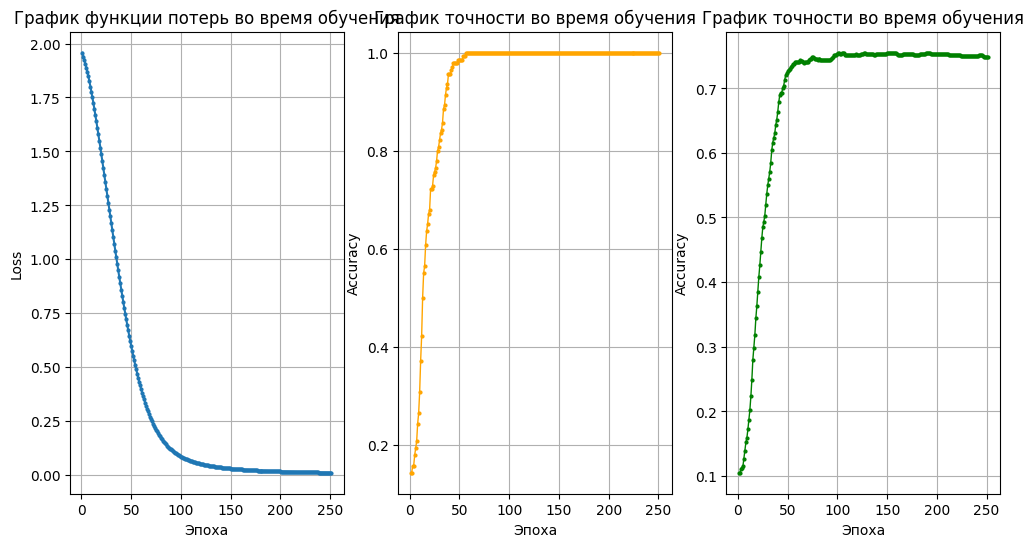

In [ ]:
epochs = list(range(1, len(losses) + 1))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.plot(epochs,  [loss.detach().numpy() for loss in losses], marker='o', linestyle='-', markersize=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('График функции потерь во время обучения')
ax1.grid(True)
ax2.plot(epochs, accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='orange')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy')
ax2.set_title('График точности во время обучения')
ax2.grid(True)
ax3.plot(epochs, test_accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='green')
ax3.set_xlabel('Эпоха')
ax3.set_ylabel('Accuracy')
ax3.set_title('График точности во время обучения')
ax3.grid(True)
plt.show()

### СРАВНЕНИЕ

МОДЕЛЬ GRN:

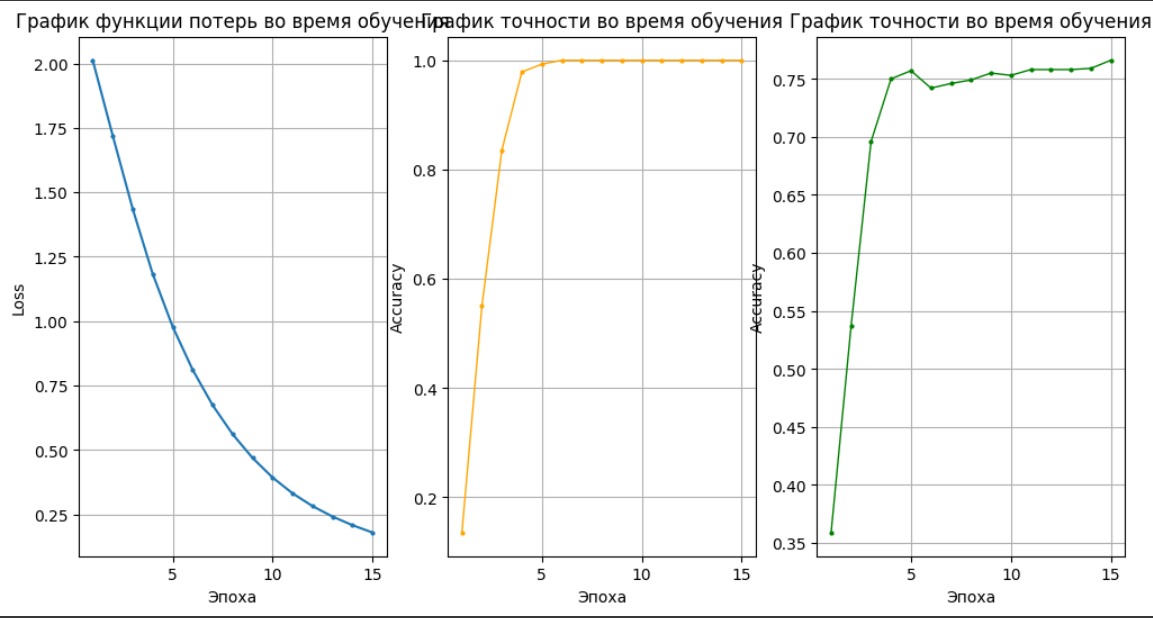

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
pred = out[data.test_mask].max(dim=1)[1]
correct = pred.eq(data.y[data.test_mask])
acc = correct.sum().item() / len(data.y[data.test_mask])
print(f"Конечная тестовая точность: {acc*100:.2f}%")

Конечная тестовая точность: 76.60%


ЛИНЕЙНАЯ МОДЕЛЬ:

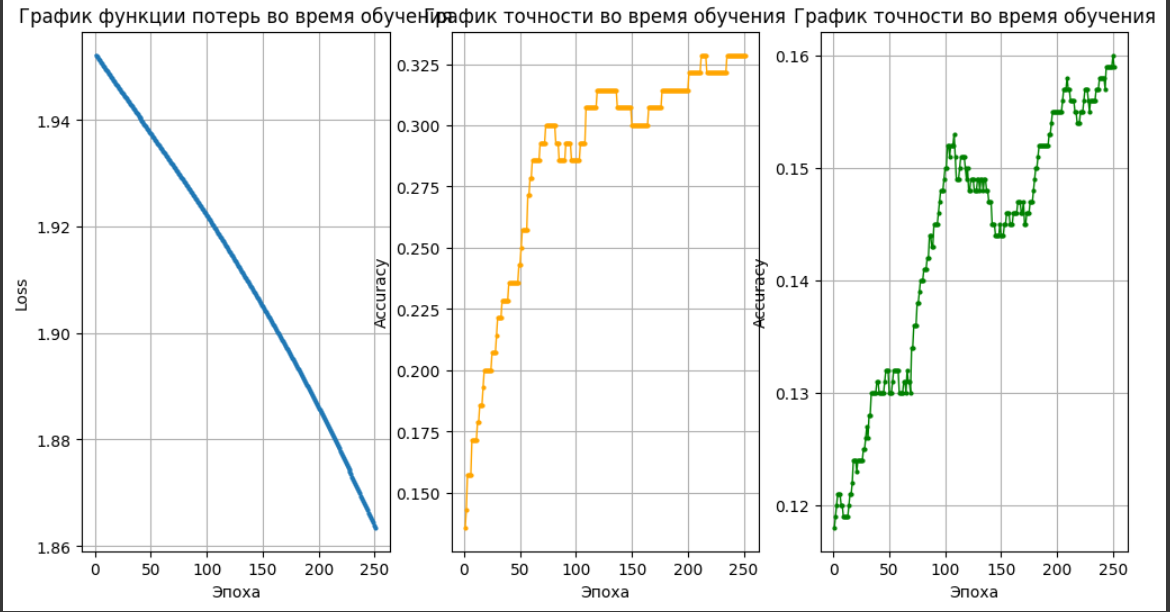

In [ ]:
model2.eval()
out = model2(data.x)
pred = out[data.test_mask].max(dim=1)[1]
correct = pred.eq(data.y[data.test_mask])
acc = correct.sum().item() / len(data.y[data.test_mask])
print(f"Конечная тестовая точность: {acc*100:.2f}%")

Конечная тестовая точность: 15.90%


МОДЕЛЬ GCN:

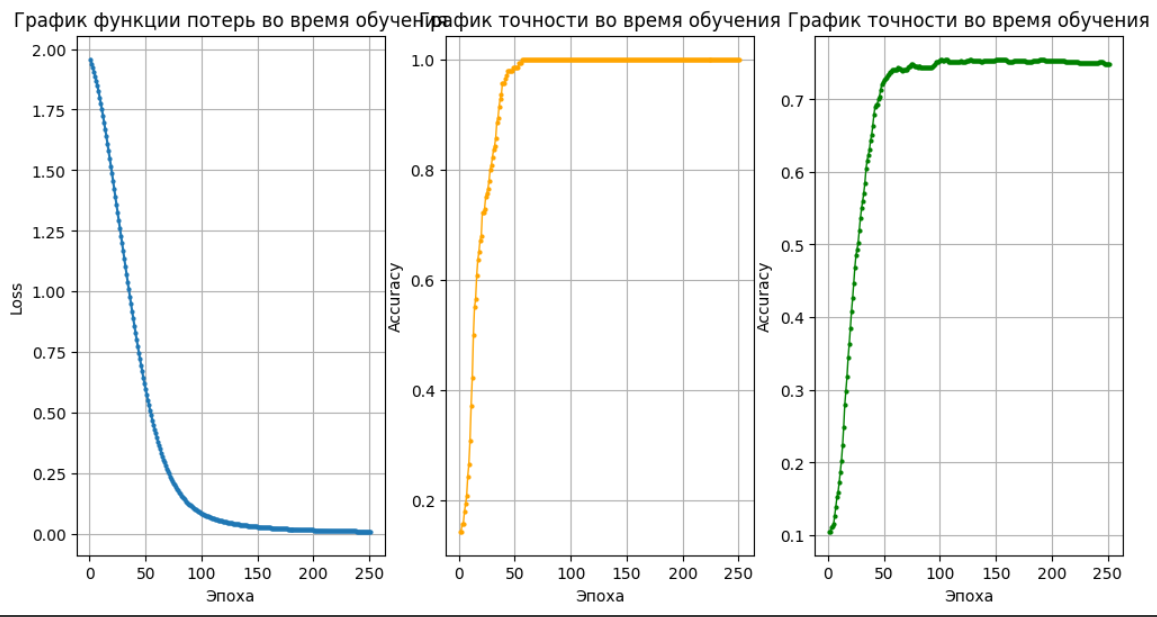

In [ ]:
model3.eval()
out, z = model3(data.x, data.edge_index)
acc = accuracy(z[data.test_mask].argmax(dim=1), data.y[data.test_mask])
print(f"Конечная тестовая точность: {acc*100:.2f}%")

Конечная тестовая точность: 74.90%
